In [ ]:
import os

root = "D:/archive3"
img_dir = os.path.join(root, "PNGImages")
mask_dir = os.path.join(root, "PedMasks")

imgs = sorted(os.listdir(img_dir))
msks = sorted(os.listdir(mask_dir))
print("Ảnh mẫu:", imgs[:5])
print("Mask mẫu:", msks[:5])


Ảnh mẫu: ['FudanPed00001.png', 'FudanPed00002.png', 'FudanPed00003.png', 'FudanPed00004.png', 'FudanPed00005.png']
Mask mẫu: ['FudanPed00001_mask.png', 'FudanPed00002_mask.png', 'FudanPed00003_mask.png', 'FudanPed00004_mask.png', 'FudanPed00005_mask.png']


In [ ]:
import os, random
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class PennFudanDataset(Dataset):
    def   __init__(self, root="D:/archive3", ids=None, transform=None):
        """
        root     : thư mục gốc PennFudanPed
        ids      : list các ảnh (chuỗi id), nếu None thì load toàn bộ và chia train/val ngoài
        transform: torchvision transform cho ảnh
        """
        self.root      = root
        self.transform = transform or transforms.ToTensor()

        imgs     = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.ids = ids if ids is not None else [i.split('.')[0] for i in imgs]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        id_ = self.ids[idx]

          # Load image
        img_path = os.path.join(self.root, "PNGImages", id_ + ".png")
        img      = Image.open(img_path).convert("RGB")
        img      = self.transform(img)

          # Load mask
        mask_path = os.path.join(self.root, "PedMasks", id_ + "_mask.png")
        msk       = np.array(Image.open(mask_path))                         # H x W, mỗi object 1 giá trị khác 0

        obj_ids = np.unique(msk)
        obj_ids = obj_ids[obj_ids != 0]

          # Tạo mask tensor: [N, H, W]
        masks = msk[None, :, :] == obj_ids[:, None, None]
        masks = torch.as_tensor(masks, dtype=torch.uint8)

          # Bounding boxes [N, 4]
        boxes = []
        for m in masks:
            pos   = m.nonzero(as_tuple=False)
            x_min = torch.min(pos[:, 1])
            y_min = torch.min(pos[:, 0])
            x_max = torch.max(pos[:, 1])
            y_max = torch.max(pos[:, 0])
            boxes.append([x_min, y_min, x_max, y_max])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # class=1: person

        target = {"boxes": boxes, "labels": labels, "masks": masks}
        return img, target

  # =======================
  # Train/val split
  # =======================
root    = "D:/archive3"
all_ids = sorted([i.split('.')[0] for i in os.listdir(os.path.join(root, "PNGImages"))])
random.seed(0)
random.shuffle(all_ids)
cut = int(0.8 * len(all_ids))
train_ids = all_ids[:cut]
val_ids = all_ids[cut:]

train_dataset = PennFudanDataset(root=root, ids=train_ids)
val_dataset   = PennFudanDataset(root=root, ids=val_ids)

# =======================
# DataLoader
# =======================
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


In [ ]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

# ============================
# 1️⃣ Tải model và chỉnh sửa đầu ra
# ============================
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model_is = maskrcnn_resnet50_fpn(weights=weights)

# Số feature đầu vào cho head box
in_features = model_is.roi_heads.box_predictor.cls_score.in_features

# Thay thế Box Predictor (2 lớp: background + person)
model_is.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes=2
)

# Thay thế Mask Predictor
in_mask = model_is.roi_heads.mask_predictor.conv5_mask.in_channels
hidden = 256
model_is.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_mask, hidden, num_classes=2
)

# Đưa model lên GPU (nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_is.to(device)

# ============================
# 2️⃣ Tối ưu hóa
# ============================
optimizer = torch.optim.SGD(
    [p for p in model_is.parameters() if p.requires_grad],
    lr=5e-3,
    momentum=0.9,
    weight_decay=1e-4
)

# ============================
# 3️⃣ Hàm train 1 epoch
# ============================
def train_one_epoch_is(model, loader, opt):
    model.train()
    loss_sum = 0.0
    n = 0
    for imgs, targets in loader:
        imgs = [im.to(device) for im in imgs]
        targets = [
            {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in t.items()}
            for t in targets
        ]

        losses = model(imgs, targets)  # dict chứa loss
        loss = sum(losses.values())

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_sum += loss.item()
        n += 1

    return loss_sum / max(n, 1)


In [ ]:
from tqdm import tqdm  # hiển thị tiến trình

num_epochs = 1  # số epochs mới, bạn có thể tăng hoặc giảm tùy nhu cầu

for e in range(num_epochs):
    running_loss = 0.0
    # Dùng tqdm để show tiến trình batch
    for images, targets in tqdm(train_loader, desc=f"Epoch {e+1}/{num_epochs}"):
        optimizer.zero_grad()
        loss_dict = model_is(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(train_loader)
    print(f"[Mask R-CNN] Epoch {e+1}/{num_epochs}: avg loss = {avg_loss:.4f}")


Epoch 1/1: 100%|██████████| 68/68 [22:17<00:00, 19.67s/it]

[Mask R-CNN] Epoch 1/1: avg loss = 0.5816


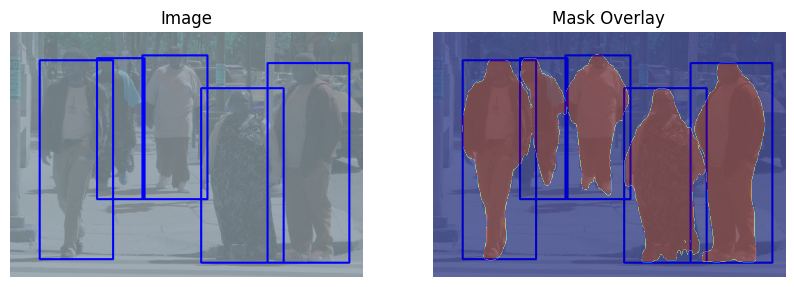

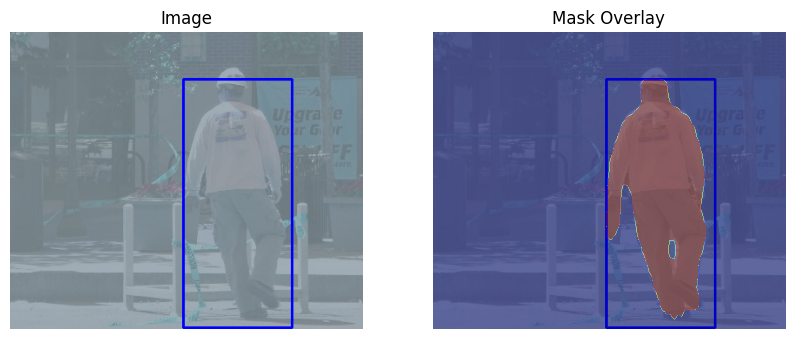

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

@torch.no_grad()
def infer_show_is(model, loader, score_thr=0.7):
    model.eval()
    imgs, targets = next(iter(loader))
    imgs_dev = [im.to(device) for im in imgs]
    outputs = model(imgs_dev)

    for i, (im, o) in enumerate(zip(imgs, outputs)):
        # tensor -> numpy và đảm bảo contiguous
        img = im.permute(1, 2, 0).cpu().numpy().copy()
        img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

        # chuyển sang uint8 + copy để tương thích cv2
        img_cv = (img * 255).astype(np.uint8).copy()
        m = np.zeros(img.shape[:2], np.float32)

        for box, score, mask, label in zip(o['boxes'].cpu(), o['scores'].cpu(),
                                           o['masks'].cpu(), o['labels'].cpu()):
            if score < score_thr:
                continue
            mask_bin = (mask[0].numpy() > 0.5).astype(np.float32)
            m = np.maximum(m, mask_bin)
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # hiển thị ảnh và mask overlay
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Image")
        plt.axis('off')
        plt.imshow(img_cv[..., ::-1])  # BGR -> RGB

        plt.subplot(1, 2, 2)
        plt.title("Mask Overlay")
        plt.axis('off')
        plt.imshow(img_cv[..., ::-1])
        plt.imshow(m, alpha=0.4, cmap='jet')
        plt.show()

# Gọi hàm inference demo
infer_show_is(model_is, val_loader)

In [ ]:
# =============================
# (iii) Fine-tuning Mask R-CNN
# =============================
num_epochs = 1  # có thể tăng lên để mô hình học tốt hơn

for e in range(num_epochs):
    tr = train_one_epoch_is(model_is, train_loader, optimizer)
    print(f"[Mask R-CNN] Epoch {e+1}: loss={tr:.4f}")

    # Lưu lại checkpoint sau mỗi epoch
    torch.save(model_is.state_dict(), f"maskrcnn_epoch{e+1}.pth")


[Mask R-CNN] Epoch 1: loss=0.2631


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import random

@torch.no_grad()
def infer_show_is(model, loader, score_thr=0.7):
    model.eval()
    imgs, targets = next(iter(loader))
    imgs_dev = [im.to(device) for im in imgs]
    outputs = model(imgs_dev)

    for i, (im, o) in enumerate(zip(imgs, outputs)):
        # Chuẩn hóa lại ảnh
        img = im.permute(1, 2, 0).cpu().numpy().copy()
        img = (img * np.array([0.229, 0.224, 0.225]) +
               np.array([0.485, 0.456, 0.406])).clip(0, 1)
        img_cv = (img * 255).astype(np.uint8).copy()

        h, w = img.shape[:2]
        overlay = np.zeros((h, w, 3), np.float32)

        for box, score, mask, label in zip(o['boxes'].cpu(),
                                           o['scores'].cpu(),
                                           o['masks'].cpu(),
                                           o['labels'].cpu()):
            if score < score_thr:
                continue

            # mask nhị phân
            mask_bin = (mask[0].numpy() > 0.5).astype(np.uint8)

            # chọn màu ngẫu nhiên cho mỗi instance
            color = [random.random(), random.random(), random.random()]
            overlay[mask_bin == 1] = color

            # vẽ bbox
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # hiển thị kết quả
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.axis('off')
        plt.imshow(img_cv[..., ::-1])

        plt.subplot(1, 2, 2)
        plt.title(f"Mask Overlay (score>{score_thr})")
        plt.axis('off')
        plt.imshow(img)
        plt.imshow(overlay, alpha=0.5)
        plt.show()


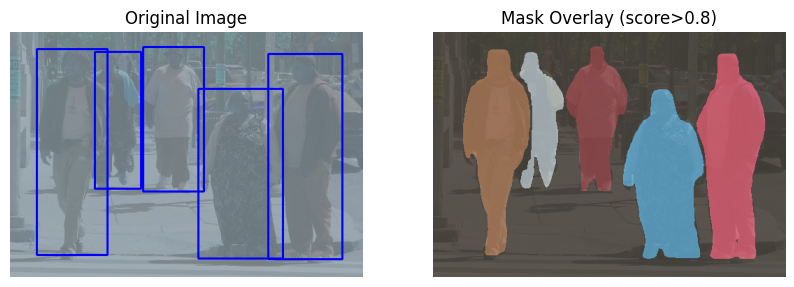

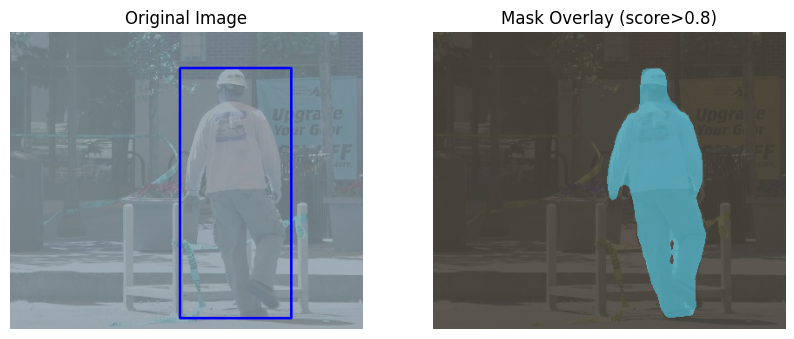

In [ ]:
infer_show_is(model_is, val_loader, score_thr=0.8)


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import random

@torch.no_grad()
def infer_show_is(model, loader, score_thr=0.7):
    model.eval()
    imgs, _ = next(iter(loader))
    imgs_dev = [im.to(device) for im in imgs]
    outputs = model(imgs_dev)

    for i, (im, o) in enumerate(zip(imgs, outputs)):
        # 1️⃣ Chuyển tensor → ảnh RGB [0,1]
        img = im.permute(1, 2, 0).cpu().numpy().copy()
        img = (img * np.array([0.229, 0.224, 0.225]) +
               np.array([0.485, 0.456, 0.406])).clip(0, 1)

        # 2️⃣ Chuẩn bị ảnh vẽ (uint8 + copy để dùng cv2)
        img_cv = (img * 255).astype(np.uint8).copy()
        h, w = img.shape[:2]
        overlay = np.zeros((h, w, 3), np.float32)

        # 3️⃣ Duyệt qua từng đối tượng được dự đoán
        for box, score, mask, label in zip(o['boxes'].cpu(),
                                           o['scores'].cpu(),
                                           o['masks'].cpu(),
                                           o['labels'].cpu()):
            if score < score_thr:
                continue

            # tạo mask nhị phân cho đối tượng hiện tại
            mask_bin = (mask[0].numpy() > 0.5).astype(np.uint8)

            # chọn màu ngẫu nhiên cho mỗi instance
            color = np.random.rand(3)
            overlay[mask_bin == 1] = color

            # vẽ bounding box
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # 4️⃣ Hiển thị kết quả
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.axis('off')
        plt.imshow(img_cv[..., ::-1])  # BGR → RGB

        plt.subplot(1, 2, 2)
        plt.title(f"Per-instance Mask (score>{score_thr})")
        plt.axis('off')
        plt.imshow(img)
        plt.imshow(overlay, alpha=0.6)
        plt.show()


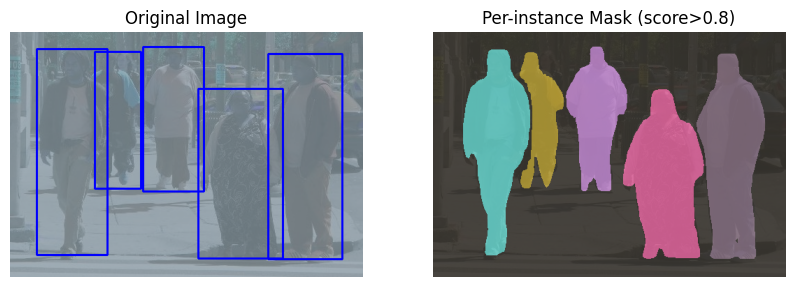

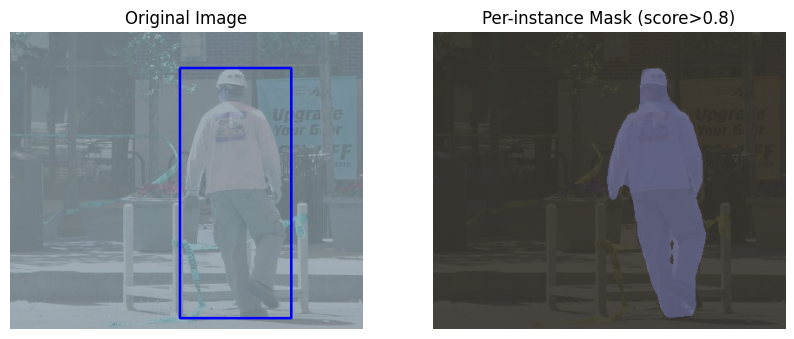

In [ ]:
infer_show_is(model_is, val_loader, score_thr=0.8)
